# graph-tool

This Jupyter notebook provides an example of using the Python packages [gravis](https://pypi.org/project/gravis) and [graph-tool](https://graph-tool.skewed.de). The .ipynb file can be found [here](https://github.com/robert-haas/gravis/tree/master/examples).

## References

- [graph-tool website](https://graph-tool.skewed.de)
  - [Documentation](https://graph-tool.skewed.de/static/doc/index.html)
    - [Quickstart](https://graph-tool.skewed.de/static/doc/quickstart.html)
    - [Cookbook](https://graph-tool.skewed.de/static/doc/demos/index.html)
    - [API reference](https://graph-tool.skewed.de/static/doc/modules.html)

## Installation

- With [pip](https://pypi.org/project/graph-tool/): Not possible without manual compilation of C++ dependencies (Boost, CGAL, expat)
- With [conda](https://anaconda.org/search?q=graph-tool): `conda install -c conda-forge graph-tool`

## Import

In [1]:
import os

import graph_tool as gt
import graph_tool.centrality
import graph_tool.collection
import graph_tool.draw
import graph_tool.generation
import graph_tool.inference

import gravis as gv

## Quick start

In [2]:
def assign_properties(g):
    # Centrality calculation
    node_centralities, edge_centralities = gt.centrality.betweenness(g)

    # Community detection
    communities = gt.inference.minimize_blockmodel_dl(g).get_blocks()

    # Graph properties
    g.graph_properties['edge_opacity'] = g.new_graph_property('double', val=0.75)  # verbose syntax
    g.gp['arrow_size'] = g.new_gp('int', val=3)                                    # shorter syntax
    g.gp['node_border_color'] = g.new_gp('string', val='black')
    g.gp['node_border_size'] = g.new_gp('float', val=0.5)

    # Node properties: Size by centrality, color by community, hover message by name
    colors = ['red', 'blue', 'green', 'orange', 'pink', 'brown', 'yellow', 'cyan', 'magenta', 'violet']
    g.vertex_properties['size'] = g.new_vertex_property('double')
    g.vp['color'] = g.new_vp('string')
    for node in g.vertices():
        g.vertex_properties['size'][node] = 7 + node_centralities[node] * 5000
        g.vertex_properties['color'][node] = colors[communities[node] % len(colors)]
    g.vp['hover'] = g.new_vp('string', vals=g.vp['name'])

    # Edge properties: Size by centrality
    g.edge_properties['size'] = g.new_edge_property('string')
    for edge in g.edges():
        g.edge_properties['size'][edge] = str(0.05 + edge_centralities[edge] * 1000)


# Create a graph from a stored example
g = gt.collection.data['serengeti-foodweb']

# Assign properties
assign_properties(g)

# Plot it
gv.d3(g, zoom_factor=0.8, show_node_label=False)

In [3]:
# Generate a mathematical graph
g = gt.generation.lattice([10, 20], periodic=True)

# Plot it
gv.d3(g, zoom_factor=0.2)

## Graph construction

### 1) Manual graph construction

- Quickstart: [Creating and manipulating graphs](https://graph-tool.skewed.de/static/doc/quickstart.html#creating-and-manipulating-graphs)
- API: [Graph](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.Graph)
  - [add_vertex](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.Graph.add_vertex)
  - [add_edge](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.Graph.add_edge)
  - [add_edge_list](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.Graph.add_edge_list)

#### 1.a) Graph (with directed=False)

undirected, with self-loops, with parallel edges, with attributes (after explicit declaration)

In [4]:
ug = gt.Graph(directed=False)


# Node with automatic id (starts from 0)
n0 = ug.add_vertex()

# Node with user-defined id
# ~ Not supported ~

# Node + attribute
# ~ Not supported ~


# Nodes
nodes = ug.add_vertex(6)  # argument: number of nodes with automatic ids
n1, n2, n3, n4, n5, n6 = nodes


# Edge (nodes may already exist but do not need to, except add_missing=False)
e0 = ug.add_edge(n0, n1, add_missing=False)
e1 = ug.add_edge(n6, 7)


# Edges
edges = ug.add_edge_list([
    (1, 2),
    (n2, 3),
    (n3, n4),
    (4, 5),
    (n5, n6),
    (7, 0),
    (0, 0),
    (n0, n0),
    (0, n1),
    (0, 1),
])


gv.d3(ug, graph_height=200)

#### 1.b) Graph (with directed=True)

In [5]:
dg = gt.Graph(directed=True)

for source, target in ug.edges():
    dg.add_edge(source, target)

gv.d3(dg, graph_height=200)

#### Assign attributes to a created graph

- [Tutorial: Property maps](https://graph-tool.skewed.de/static/doc/quickstart.html#property-maps)
    - Property maps are a way of **associating additional information to** the **vertices**, **edges** or to the **graph** itself.
    - Three types of property maps: VertexPropertyMap, EdgePropertyMap, and GraphPropertyMap
    - Each created property map has an associated **value type**, which must be chosen from the predefined set
        - bool, int, long, float, string, vector, ...
    - New property maps can be created for a given graph by calling one of the methods
        - `new_vertex_property()` alias `new_vp()`
        - `new_edge_property()` alias `new_ep()`
        - `new_graph_property()` alias `new_gp()`
    - Any created property map can be **made “internal”** to the corresponding graph (=copied and saved to a file together with the graph), by including them in the **graph’s dictionary-like attributes**
        - `vertex_properties` alias `vp`
        - `edge_properties` alias `ep`
        - `graph_properties` alias `gp`

In [6]:
g = gt.Graph(directed=False)
edges = g.add_edge_list([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 0)])

Graph attributes

In [7]:
# verbose
g.graph_properties['background_color'] = g.new_graph_property(value_type='string', val='gray')

# shorter
g.gp['node_shape'] = g.new_gp('string', 'rectangle')
g.gp['node_label_color'] = g.new_gp('string', 'white')
g.gp['edge_opacity'] = g.new_gp('float', 0.3)

Node attributes

In [8]:
# Nodes
num_nodes = len(list(g.vertices()))
g.vertex_properties['size'] = g.new_vertex_property(value_type='int', vals=[5 + i*5 for i in range(num_nodes)])
g.vp['color'] = g.new_vp('string', ['lightblue'] * num_nodes)

# Node
g.vertex_properties['shape'] = g.new_vertex_property('string')  # verbose
g.vp['opacity'] = g.new_vp('float')  # shorter
g.vp['color'][3] = 'darkred'
g.vp['shape'][3] = 'hexagon'
g.vp['size'][3] = 40
g.vp['opacity'][3] = 0.3

Edge attributes

In [9]:
# Edges
num_edges = len(list(g.edges()))
g.edge_properties['size'] = g.new_edge_property(value_type='int', vals=[1 + i for i in range(num_edges)])
g.ep['color'] = g.new_ep('string', ['lightgreen'] * num_edges)

# Edge
e34 = g.edge(3, 4)
g.edge_properties['size'][e34] = 1
g.ep['color'][e34] = 'darkred'

In [10]:
gv.d3(g, graph_height=200, use_centering_force=False)

### 2) Algorithmic graph creation

- [Docs: graph_tool.generation - Random graph generation](https://graph-tool.skewed.de/static/doc/generation.html#graph_tool.generation)

In [11]:
n = 20

In [12]:
g = gt.generation.price_network(n)
g = gt.generation.lattice([10, 20], periodic=True)

### 3) Graph loading from an internal collection

In [13]:
# Neural network of the C. elegans worm
g = gt.collection.data['celegansneural']

### 4) Graph import and export

#### Import

- [API: load_graph](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.load_graph)
- [API: load](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.Graph.load)

In [14]:
filepath = os.path.join('data', 'graph-tool_graph.xml.gz')
g = gt.load_graph(filepath)

#### Export

- [API: save](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.Graph.save)

In [15]:
filepath = os.path.join('data', 'graph-tool_graph.xml.gz')
g.save(filepath)

## Basic graph inspection

### 1) Graph and its properties

In [16]:
v0 = g.vertex(0)
g.vertex_index[v0]

0

### 2) Nodes and their properties

In [17]:
for node in g.vertices():
    node_id = node
    #attributes = node.attributes()
    #degree = node.degree()
    print('Type:', type(node))#, type(attributes))
    print('Id:', node_id)
    #print('Attributes:', attributes)
    #print('Degree:', degree)
    break

Type: <class 'graph_tool.libgraph_tool_core.Vertex'>
Id: 0


### 3) Edges and their properties

In [18]:
for edge in g.edges():
    source = edge.source()
    target = edge.target()
    #attributes = edge.attributes()
    print('Type:', type(edge), type(source), type(target))#, type(attributes))
    print('Source:', source)
    print('Target:', target)
    print(str(source))
    #print('Attributes:', )
    break

Type: <class 'graph_tool.libgraph_tool_core.Edge'> <class 'graph_tool.libgraph_tool_core.Vertex'> <class 'graph_tool.libgraph_tool_core.Vertex'>
Source: 0
Target: 1
0


## Calculating graph measures and metrics

### 1) Quantitative measures

#### Centrality

- [API: graph_tool.centrality](https://graph-tool.skewed.de/static/doc/centrality.html): Centrality measures

In [19]:
# PageRank of each vertex
node_property_map = gt.centrality.pagerank(g)

# closeness centrality for each vertex
node_property_map = gt.centrality.closeness(g)

# Katz centrality of each vertex in the graph
node_property_map = gt.centrality.katz(g)

In [20]:
# Eigenvector centrality of each vertex in the graph, as well as the largest eigenvalue
largest_eigenvalue, node_property_map = gt.centrality.eigenvector(g)

# Authority and hub centralities of each vertex in the graph
largest_eigenvalue, node_property_map1, node_property_map2 = gt.centrality.hits(g)

In [21]:
# Betweenness centrality for each vertex and edge
node_property_map_betweenness, edge_property_map = gt.centrality.betweenness(g)

# central point dominance of the graph, given the betweenness centrality of each vertex
scalar = gt.centrality.central_point_dominance(g, node_property_map_betweenness)

In [22]:
trust_map = g.new_edge_property('double')

# Eigentrust centrality of each vertex in the graph
node_property_map_matrix = gt.centrality.eigentrust(g, trust_map)

# Pervasive trust transitivity between chosen (or all) vertices in the graph
node_property_map_matrix = gt.centrality.trust_transitivity(g, trust_map)

### 2) Structure inference

#### Community detection and graph partitioning

- [Cookbook: Inferring modular network structure](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html)
- [API: graph_tool.inference](https://graph-tool.skewed.de/static/doc/inference.html#): Statistical inference of generative network models

In [23]:
g = gt.collection.data['celegansneural']

In [24]:
state = gt.inference.minimize_blockmodel_dl(g)
node_property_map = state.get_blocks()

In [25]:
state = gt.inference.minimize_nested_blockmodel_dl(g)
state.print_summary()
levels = state.get_levels()
node_property_map = levels[0].get_blocks()

l: 0, N: 297, B: 16
l: 1, N: 16, B: 6
l: 2, N: 6, B: 2
l: 3, N: 2, B: 1
l: 4, N: 1, B: 1


In [26]:
state = gt.inference.EMBlockState(g, B=3)  # B is number of desired blocks
node_property_map_expectations = state.get_vertex_marginals()

In [27]:
# TODO: more algorithms

#### Minimum spanning tree

- [API: min_spanning_tree](https://graph-tool.skewed.de/static/doc/topology.html#graph_tool.topology.min_spanning_tree)

In [28]:
edge_map = gt.topology.min_spanning_tree(g)

## Graph visualization

- [API: graph_tool.draw](https://graph-tool.skewed.de/static/doc/draw.html): Graph drawing and layout

### Static plots

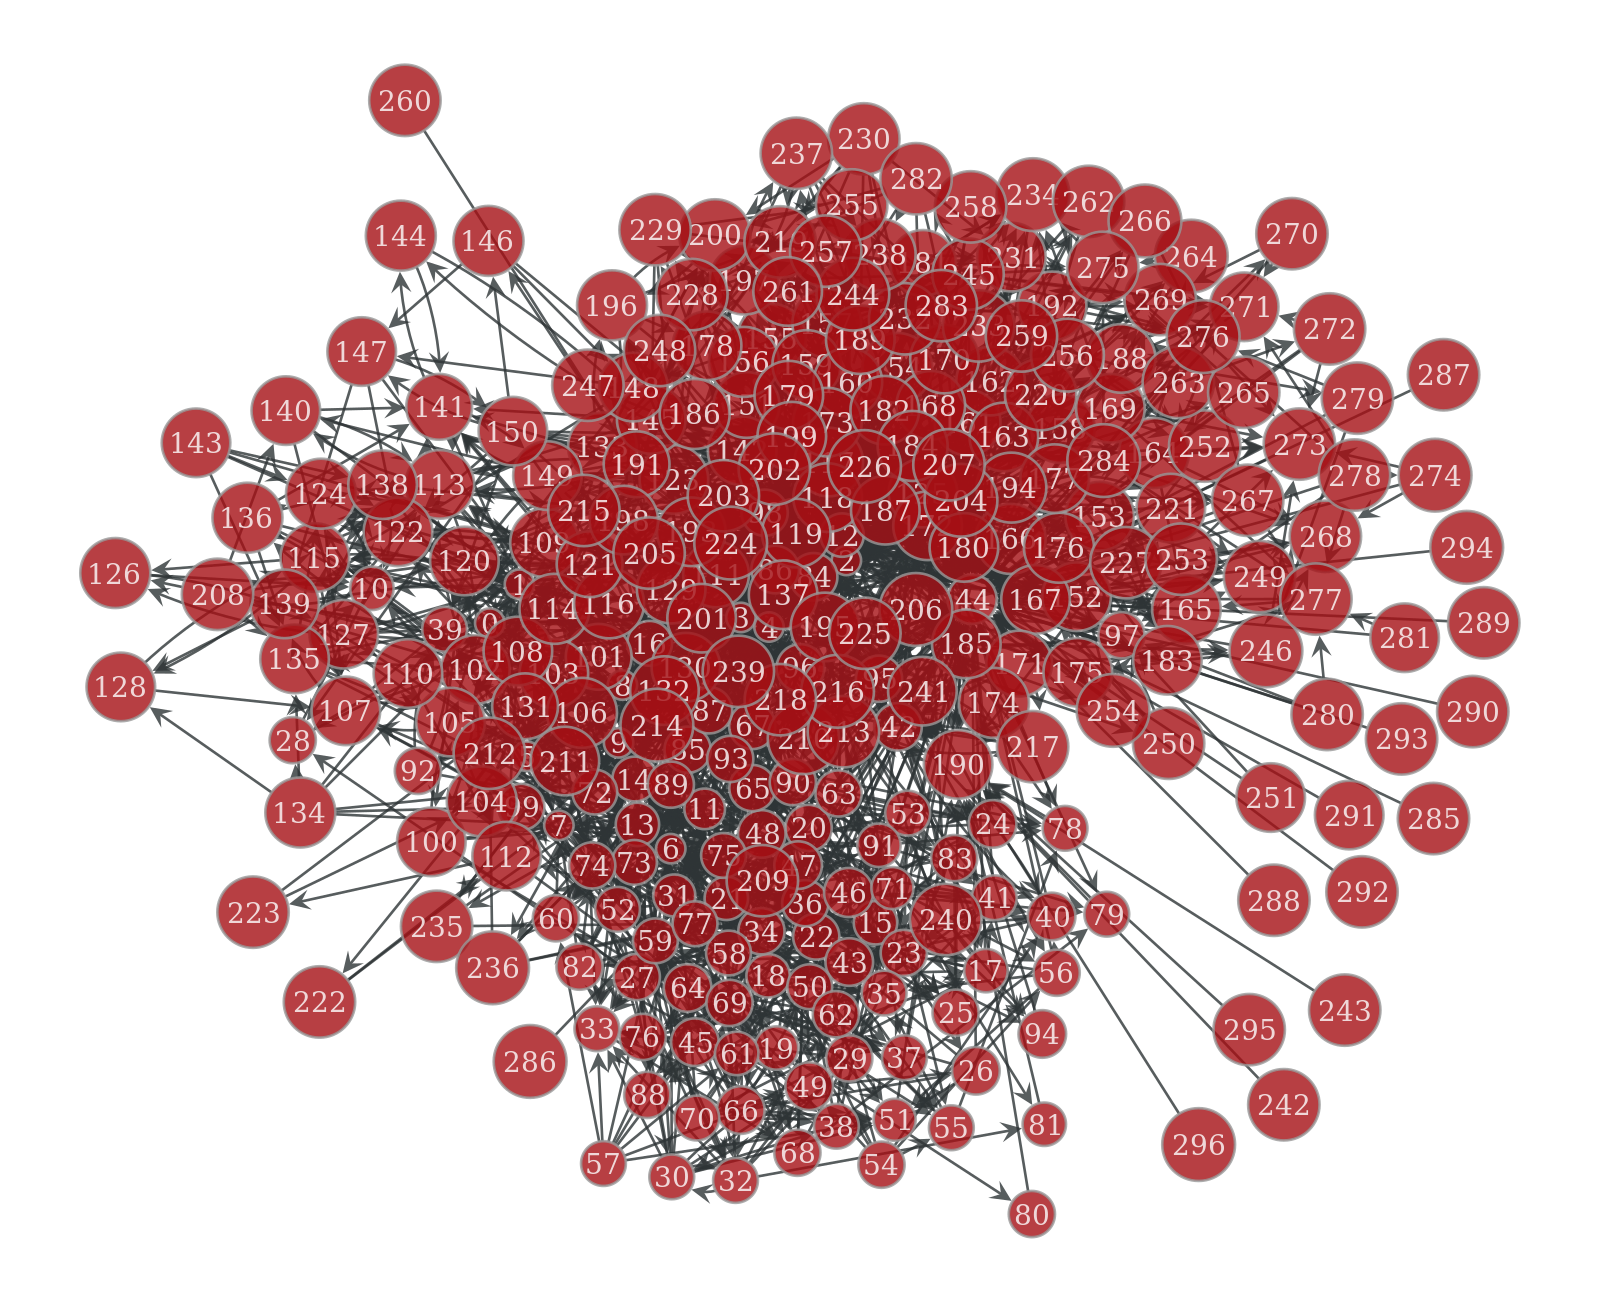

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc8602f0a50, at 0x7fc809acdf10>

In [29]:
gt.draw.graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=14, output_size=(800, 800))

### Dynamic animations

In [30]:
# TODO